# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

In [1940]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import statistics

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings 
from sklearn.preprocessing import MinMaxScaler
filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

In [1725]:
df = pd.read_csv('data/vehicles.csv')

In [1726]:
df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [1729]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [1731]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [1733]:
df.dropna(inplace = True)

In [1735]:
# drop NaN
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
126,7305672709,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,68472.0,clean,automatic,1GCWGAFP8J1309579,rwd,full-size,van,white,al
127,7305672266,auburn,0,2019.0,chevrolet,express cargo van,like new,6 cylinders,gas,69125.0,clean,automatic,1GCWGAFP4K1214373,rwd,full-size,van,white,al
128,7305672252,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,66555.0,clean,automatic,1GCWGAFPXJ1337903,rwd,full-size,van,white,al
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [1738]:
# How many models are there?  Yikes! 5139!
df['model'].value_counts()

model
f-150                        943
silverado 1500               929
1500                         482
2500                         332
sierra 1500                  330
                            ... 
5 sport                        1
titan king cab                 1
4runner sport edition 4wd      1
mustang cobra                  1
cruze, 2lt                     1
Name: count, Length: 5139, dtype: int64

In [1740]:
# drop price = 0
df = df[df['price'] != 0]

In [1742]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al
268,7315946365,birmingham,9000,2008.0,mazda,miata mx-5,excellent,4 cylinders,gas,56700.0,clean,automatic,JM1NC25F570128735,rwd,compact,convertible,white,al
337,7315354216,birmingham,8950,2011.0,ford,f-150,excellent,6 cylinders,gas,164000.0,clean,automatic,1FTMF1CM6BKD55331,fwd,full-size,truck,white,al
338,7315349921,birmingham,4000,1972.0,mercedes-benz,benz,fair,6 cylinders,gas,88100.0,clean,automatic,1.14023E+13,rwd,full-size,coupe,silver,al


In [1744]:
# How many vehicle types since there are too many models.  
# Reasonable, there are 13
df['type'].value_counts()

type
SUV            8618
sedan          7821
truck          6955
pickup         2567
van            1656
coupe          1410
hatchback      1091
convertible     796
wagon           774
mini-van        590
other            94
offroad          81
bus              43
Name: count, dtype: int64

In [1746]:
# How many size types are there 
# Reasonable, there are 4
df['size'].value_counts()

size
full-size      19178
mid-size        8922
compact         3810
sub-compact      586
Name: count, dtype: int64

In [1748]:
# How many condition types are there 
# There are 6
df['condition'].value_counts()

condition
excellent    18259
good          9772
like new      3772
fair           488
new            169
salvage         36
Name: count, dtype: int64

In [1750]:
# How many fuel types are there 
# There are 5
df['fuel'].value_counts()

fuel
gas         29175
diesel       2824
hybrid        389
electric       76
other          32
Name: count, dtype: int64

In [1752]:
# How many cylinder types are there
# There are 8
df['cylinders'].value_counts()

cylinders
6 cylinders     10794
4 cylinders     10661
8 cylinders     10053
10 cylinders      548
5 cylinders       271
other              92
3 cylinders        66
12 cylinders       11
Name: count, dtype: int64

In [1754]:
# How many titile types are there
# There are 6
df['title_status'].value_counts()

title_status
clean         31321
rebuilt         786
salvage         239
lien            134
missing          14
parts only        2
Name: count, dtype: int64

In [1756]:
# How many paint colors are there
# There are 12
df['paint_color'].value_counts()

paint_color
white     9092
black     5994
silver    4483
grey      3989
blue      3141
red       2900
custom     868
green      842
brown      748
yellow     215
orange     152
purple      72
Name: count, dtype: int64

In [1758]:
# How many states are there
# There are 51
df['state'].value_counts()

state
fl    3398
ca    3332
ny    1722
tx    1299
mi    1222
wi    1111
nc    1094
oh    1033
ia    1030
pa    1000
or     984
va     979
tn     863
mn     795
nj     789
co     759
vt     676
ma     656
il     634
id     604
ks     603
az     599
in     565
ky     543
ok     501
sc     449
al     419
ak     403
mo     381
mt     348
wa     312
ct     298
ga     270
nm     238
ri     231
nv     221
hi     207
me     197
nh     192
dc     182
md     161
ut     153
sd     149
ar     145
ne     134
la     133
nd     133
de     109
wv      88
wy      87
ms      65
Name: count, dtype: int64

In [1760]:
# How many manufacturers are there
# There are 41
df['manufacturer'].value_counts()

manufacturer
ford               6956
chevrolet          4872
toyota             2682
honda              1821
nissan             1602
ram                1451
gmc                1355
jeep               1281
dodge               909
subaru              875
bmw                 863
mercedes-benz       804
hyundai             727
volkswagen          717
lexus               581
kia                 572
chrysler            514
cadillac            469
audi                409
mazda               381
buick               359
mitsubishi          323
lincoln             246
acura               240
volvo               238
infiniti            226
pontiac             198
mini                167
rover               158
porsche             135
saturn               97
jaguar               82
mercury              81
fiat                 47
tesla                19
alfa-romeo           15
ferrari               9
harley-davidson       7
datsun                3
aston-martin          3
land rover            2
Nam

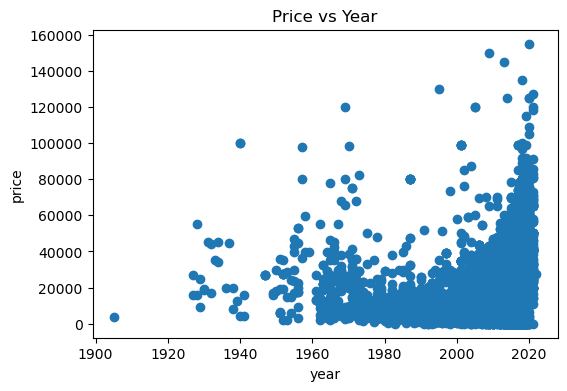

In [1762]:
# create a plot of the pricing to see if there are outliers

fix, ax = plt.subplots(figsize=(6,4))
ax.scatter(df['year'],df['price'])
ax.set_title('Price vs Year')
ax.set_xlabel('year')
ax.set_ylabel('price')
plt.show()


In [1764]:
df['price'].describe()

count     32496.000000
mean      16993.479013
std       13219.394890
min           1.000000
25%        7500.000000
50%       13125.500000
75%       23395.000000
max      155000.000000
Name: price, dtype: float64

In [1766]:
df['year'].info()

<class 'pandas.core.series.Series'>
Index: 32496 entries, 215 to 426833
Series name: year
Non-Null Count  Dtype  
--------------  -----  
32496 non-null  float64
dtypes: float64(1)
memory usage: 507.8 KB


In [1768]:
# cast the year as integers

df['year'] = df['year'].astype(int)

In [1770]:
# create an array that has the pricing value upper limit of 2*std+mean so we can
# filter outliers
sigma_threshold = []

for i in range (1905, 2023, 1):
    loop_mean = df[df['year'] == i]['price'].mean()
    loop_std = df[df['year'] == i]['price'].std()
    sigma_threshold.append(loop_mean + 2 * loop_std)

In [1772]:
# let's filter out the outliers in pricing

df_filt_sigma = df.copy()

for i in range (1905, 2023, 1):
    value = sigma_threshold[i-1905]
    if not math.isnan(value):
        df_filt_sigma[df_filt_sigma['year'] == i] = df_filt_sigma[(df_filt_sigma['year'] == i) & (df_filt_sigma['price'] < value)]

# drop null values
df_filt_sigma.dropna(inplace=True)
df_filt_sigma.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30852 entries, 215 to 426833
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            30852 non-null  float64
 1   region        30852 non-null  object 
 2   price         30852 non-null  float64
 3   year          30852 non-null  float64
 4   manufacturer  30852 non-null  object 
 5   model         30852 non-null  object 
 6   condition     30852 non-null  object 
 7   cylinders     30852 non-null  object 
 8   fuel          30852 non-null  object 
 9   odometer      30852 non-null  float64
 10  title_status  30852 non-null  object 
 11  transmission  30852 non-null  object 
 12  VIN           30852 non-null  object 
 13  drive         30852 non-null  object 
 14  size          30852 non-null  object 
 15  type          30852 non-null  object 
 16  paint_color   30852 non-null  object 
 17  state         30852 non-null  object 
dtypes: float64(4), object(14)
me

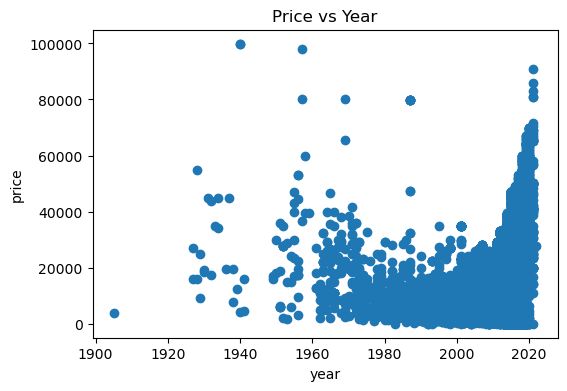

In [1784]:
# create a plot of the pricing to see if there are outliers
# looks a bit cleaner

fix, ax = plt.subplots(figsize=(6,4))
ax.scatter(df_filt_sigma['year'],df_filt_sigma['price'])
ax.set_title('Price vs Year')
ax.set_xlabel('year')
ax.set_ylabel('price')
plt.show()

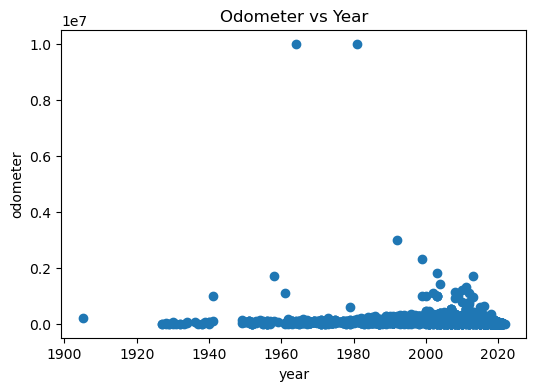

In [1776]:
# create a plot of the odometer to see if there are outliers

fix, ax = plt.subplots(figsize=(6,4))
ax.scatter(df_filt_sigma['year'],df_filt_sigma['odometer'])
ax.set_title('Odometer vs Year')
ax.set_xlabel('year')
ax.set_ylabel('odometer')
plt.show()

In [1778]:
# repeat what we did for pricing for the odometer

# create an array that has the odometer value upper limit of 2*std+mean so we can
# filter outliers
sigma_threshold_odom = []

for i in range (1905, 2023, 1):
    loop_mean = df[df['year'] == i]['odometer'].mean()
    loop_std = df[df['year'] == i]['odometer'].std()
    sigma_threshold_odom.append(loop_mean + 2 * loop_std)

# let's filter out the outliers in odometer

for i in range (1905, 2023, 1):
    value = sigma_threshold_odom[i-1905]
    if not math.isnan(value):
        df_filt_sigma[df_filt_sigma['year'] == i] = df_filt_sigma[(df_filt_sigma['year'] == i) & (df_filt_sigma['odometer'] < value)]

# drop null values
df_filt_sigma.dropna(inplace=True)
df_filt_sigma.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30040 entries, 215 to 426833
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            30040 non-null  float64
 1   region        30040 non-null  object 
 2   price         30040 non-null  float64
 3   year          30040 non-null  float64
 4   manufacturer  30040 non-null  object 
 5   model         30040 non-null  object 
 6   condition     30040 non-null  object 
 7   cylinders     30040 non-null  object 
 8   fuel          30040 non-null  object 
 9   odometer      30040 non-null  float64
 10  title_status  30040 non-null  object 
 11  transmission  30040 non-null  object 
 12  VIN           30040 non-null  object 
 13  drive         30040 non-null  object 
 14  size          30040 non-null  object 
 15  type          30040 non-null  object 
 16  paint_color   30040 non-null  object 
 17  state         30040 non-null  object 
dtypes: float64(4), object(14)
me

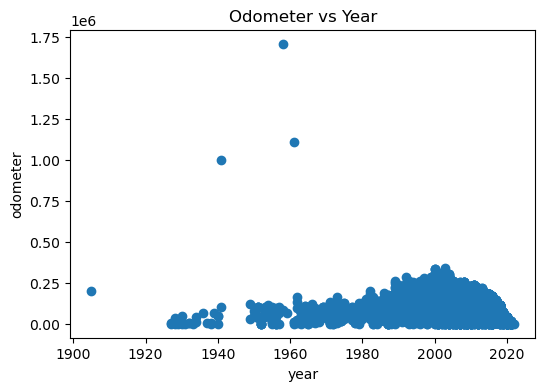

In [1786]:
# create a plot of the odomoter to see if there are outliers
# looks cleaner now

fix, ax = plt.subplots(figsize=(6,4))
ax.scatter(df_filt_sigma['year'],df_filt_sigma['odometer'])
ax.set_title('Odometer vs Year')
ax.set_xlabel('year')
ax.set_ylabel('odometer')
plt.show()

In [1630]:
# drop everything before 2001
df_filt_sigma = df_filt_sigma[df_filt_sigma['year'] >= 2001]

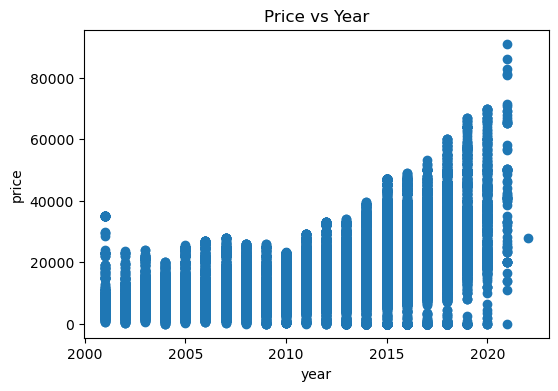

In [1711]:
fix, ax = plt.subplots(figsize=(6,4))
ax.scatter(df_filt_sigma['year'],df_filt_sigma['price'])
ax.set_title('Price vs Year')
ax.set_xlabel('year')
ax.set_ylabel('price')
plt.show()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [1635]:
# we need to map the descriptive car type
# to a numerical value, organizing based off
# my best assessment for how the price will
# increase based off vehicle type, e.g.
# bus, 12 will be worth more than a sedan, 1
# and drop other

type_mapping = {'sedan': 1, 
                'coupe': 2,
                'hatchback': 3,
                'convertible': 4,
                'truck': 5,
                'pickup': 6,
                'wagon': 7,
                'SUV': 8, 
                'mini-van': 9,
                'van': 10,
                'offroad': 11,
                'bus': 12,
                'other': np.nan}

# we need to map the descriptive car size
# to a numerical value, organizing based off
# my best assessment for how the price will
# increase based off vehicle size, e.g.
# full-size, 4, will be worth more than a 
# sub-compact 1

size_mapping = {'full-size': 4,
                'mid-size': 3,
                'compact': 2,
                'sub-compact': 1}

# we need to map the descriptive car condition
# to a numerical value, organizing based off
# my best assessment for how the price will
# increase based off vehicle condition, e.g.
# new, 6, will be worth more than a 
# salvage, 1

condition_mapping = {'excellent': 4,
                     'good': 3,
                     'like new': 5,
                     'fair': 2,
                     'new': 6,
                     'salvage': 1}

# we need to map the descriptive car fuel
# to a numerical value, organizing based off
# my best assessment for how the price will
# increase based off vehicle fuel, e.g.
# electric, 4, will be worth more than a 
# gas, 1 and drop other

fuel_mapping = {'gas': 1,
                'diesel': 2,
                'hybrid': 3,
                'electric': 4,
                'other': np.nan}

# we need to map the descriptive car cylinder
# to a numerical value, organizing based off
# my best assessment for how the price will
# increase based off vehicle cylinders, e.g.
# 12 cylinders, 7, will be worth more than a 
# 3 cylinders, 1 and drop other

cylinder_mapping = {'3 cylinders': 1,
                    '4 cylinders': 2,
                    '5 cylinders': 3,
                    '6 cylinders': 4,
                    '8 cylinders': 5,
                    '10 cylinders': 6,
                    '12 cylinders': 7,
                    'other': np.nan}

# we need to map the descriptive car title
# to a numerical value, organizing based off
# my best assessment for how the price will
# increase based off vehicle title status, e.g.
# clean, 6, will be worth more than a 
# parts only, 1

title_mapping = {'clean': 6,
                 'rebuilt': 4,
                 'salvage': 3,
                 'lien': 5,
                 'missing': 2,
                 'parts only': 1}

# we need to map the descriptive car color
# to a numerical value, organizing based off
# internet research for how the price will
# increase based off vehicle color, e.g.
# white, 12, will be worth more than a 
# brown car, 1

paint_mapping =  {'white': 12,
               'black': 11,
               'silver': 10,
               'grey': 9,
               'blue': 8,
               'red': 7,
               'custom': 6,
               'green': 5,
               'brown': 1,
               'yellow': 4,
               'orange': 3,
               'purple': 2}

# we need to map the descriptive car state
# to a numerical value, organizing based off
# internet research for used cars in highest
# vs low resale market by state
# source https://www.iseecars.com/used-car-buying-by-state-study
# dc = md

state_mapping = {'fl': 41,
                 'ca': 42,
                 'ny': 43,
                 'tx': 46,
                 'mi': 10,
                 'wi': 19,
                 'nc': 33,
                 'oh': 3,
                 'ia': 7,
                 'pa': 12,
                 'or': 29,
                 'va': 5,
                 'tn': 18,
                 'mn': 8,
                 'nj': 20,
                 'co': 30,
                 'vt': 15,
                 'ma': 25,
                 'il': 24,
                 'id': 47,
                 'ks': 21,
                 'az': 26,
                 'in': 2,
                 'ky': 6,
                 'ok': 35,
                 'sc': 22,
                 'al': 27,
                 'ak': 48,
                 'mo': 17,
                 'mt': 30,
                 'wa': 23,
                 'ct': 4,
                 'ga': 39,
                 'nm': 45,
                 'ri': 32,
                 'nv': 40,
                 'hi': 9,
                 'me': 28,
                 'nh': 16,
                 'dc': 14,
                 'md': 14,
                 'ut': 31,
                 'sd': 36,
                 'ar': 44,
                 'ne': 13,
                 'la': 34,
                 'nd': 37,
                 'de': 11,
                 'wv': 38,
                 'wy': 50,
                 'ms': 44}

# we need to map the descriptive car manufacturer
# to a numerical value, organizing based off
# a rough grouping of daily drivers to luxury
# cars, e.g. ford with a value of 1 to land rover
# value of 40

manufacturer_mapping = {'ford': 1, 
                        'chevrolet': 2,  
                        'toyota': 3,  
                        'honda': 4,  
                        'nissan': 5,  
                        'ram': 6,  
                        'gmc': 7,  
                        'jeep': 8,  
                        'dodge': 9,  
                        'subaru': 10,  
                        'hyundai': 11,  
                        'volkswagen': 12,  
                        'kia': 13,  
                        'cadillac': 14,  
                        'mazda': 15,  
                        'buick': 16,  
                        'mitsubishi': 17,   
                        'pontiac': 18,  
                        'mini': 19,                 
                        'saturn': 20,  
                        'jaguar': 21,  
                        'mercury': 22,  
                        'datsun': 23,  
                        'fiat': 24,  
                        'tesla': 25,  
                        'alfa-romeo': 26,
                        'rover': 27, 
                        'chrysler': 28, 
                        'lincoln': 29,  
                        'acura': 30,  
                        'volvo': 31,  
                        'infiniti': 32, 
                        'lexus': 33,  
                        'audi': 34, 
                        'bmw': 35,  
                        'mercedes-benz': 36, 
                        'porsche': 37, 
                        'ferrari': 38,  
                        'harley-davidson': np.nan,  
                        'aston-martin': 39,  
                        'land rover': 40}

# Map the values
df_filt_sigma['type_code'] = df_filt_sigma['type'].map(type_mapping)
df_filt_sigma['size_code'] = df_filt_sigma['size'].map(size_mapping)
df_filt_sigma['condition_code'] = df_filt_sigma['condition'].map(condition_mapping)
df_filt_sigma['fuel_code'] = df_filt_sigma['fuel'].map(fuel_mapping)
df_filt_sigma['cylinder_code'] = df_filt_sigma['cylinders'].map(cylinder_mapping)
df_filt_sigma['title_code'] = df_filt_sigma['title_status'].map(title_mapping)
df_filt_sigma['paint_code'] = df_filt_sigma['paint_color'].map(paint_mapping)
df_filt_sigma['state_code'] = df_filt_sigma['state'].map(state_mapping)
df_filt_sigma['manufacturer_code'] = df_filt_sigma['manufacturer'].map(manufacturer_mapping)

In [1637]:
# drop the 'other' values from the analysis

df_filt_sigma.dropna(inplace=True)
df_filt_sigma[df_filt_sigma.isna().any(axis=1)]

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,...,state,type_code,size_code,condition_code,fuel_code,cylinder_code,title_code,paint_code,state_code,manufacturer_code


(2000.0, 2023.0)

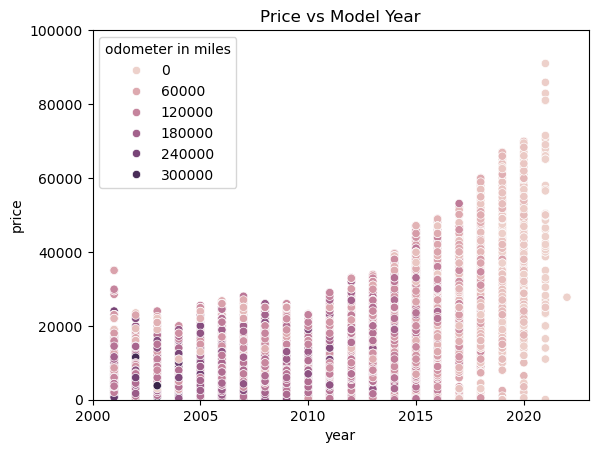

In [1639]:
sns.scatterplot(data=df_filt_sigma, x="year", y="price", hue="odometer")
plt.title("Price vs Model Year")
plt.legend(title='odometer in miles')
plt.ylim(0, 100000)
plt.xlim(2000, 2023)


(2000.0, 2023.0)

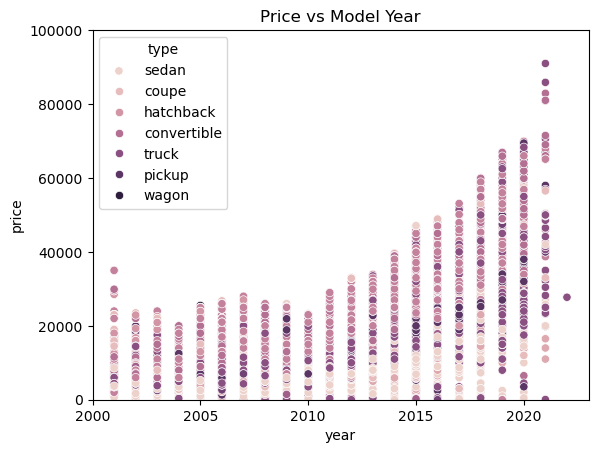

In [1640]:
sns.scatterplot(data=df_filt_sigma, x="year", y="price", hue="type_code")
plt.title("Price vs Model Year")
plt.legend(title='type', labels = ['sedan','coupe','hatchback','convertible','truck','pickup','wagon','SUV','mini-van','van','offroad','bus'])
plt.ylim(0, 100000)
plt.xlim(2000, 2023)

(2000.0, 2023.0)

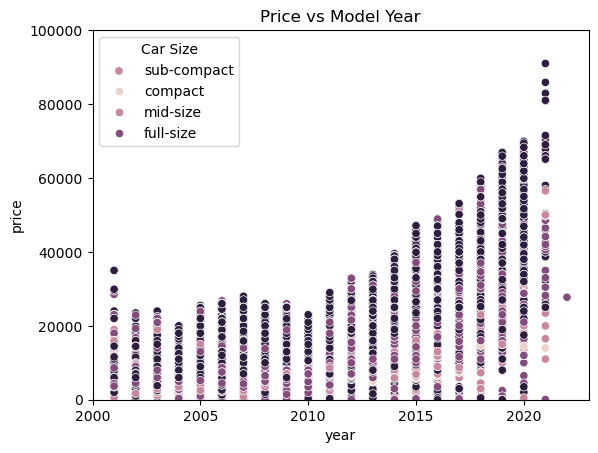

In [1642]:
# larger size cars tend to have a higher price

sns.scatterplot(data=df_filt_sigma, x="year", y="price", hue="size_code")
plt.title("Price vs Model Year")
plt.legend(title='Car Size', labels=['sub-compact','compact','mid-size','full-size'])
plt.ylim(0, 100000)
plt.xlim(2000, 2023)

(2000.0, 2023.0)

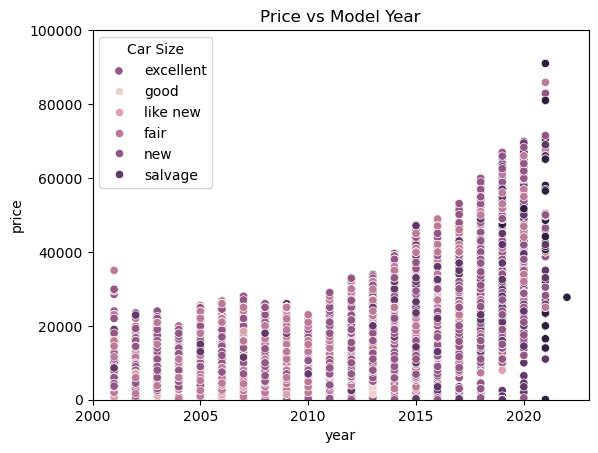

In [1644]:
sns.scatterplot(data=df_filt_sigma, x="year", y="price", hue="condition_code")
plt.title("Price vs Model Year")
plt.legend(title='Car Size', labels=['excellent','good','like new','fair','new','salvage'])
plt.ylim(0, 100000)
plt.xlim(2000, 2023)

(2000.0, 2023.0)

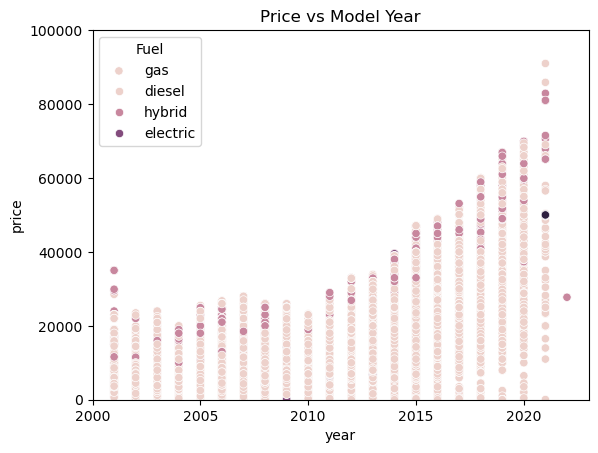

In [1645]:
# alternative fuel cars like diesel, hybrid and electrics
# tend to have a higher price

sns.scatterplot(data=df_filt_sigma, x="year", y="price", hue="fuel_code")
plt.title("Price vs Model Year")
plt.legend(title='Fuel', labels=['gas','diesel','hybrid','electric'])
plt.ylim(0, 100000)
plt.xlim(2000, 2023)

(2000.0, 2023.0)

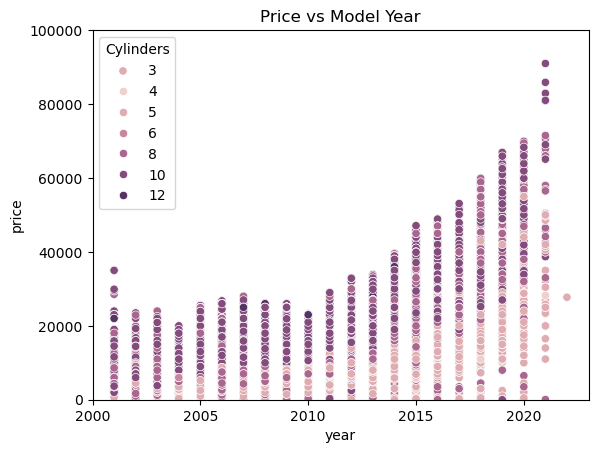

In [1647]:
# more cylinders tend to have a higher price

sns.scatterplot(data=df_filt_sigma, x="year", y="price", hue="cylinder_code")
plt.title("Price vs Model Year")
plt.legend(title='Cylinders', labels=['3','4','5','6','8','10','12'])
plt.ylim(0, 100000)
plt.xlim(2000, 2023)

(2000.0, 2023.0)

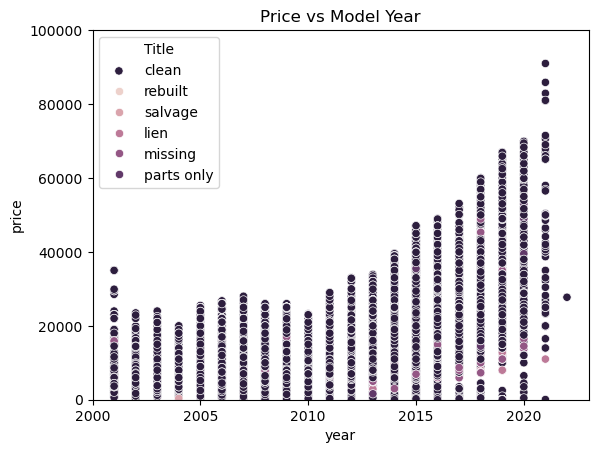

In [1649]:
sns.scatterplot(data=df_filt_sigma, x="year", y="price", hue="title_code")
plt.title("Price vs Model Year")
plt.legend(title='Title', labels=['clean','rebuilt','salvage','lien','missing','parts only'])
plt.ylim(0, 100000)
plt.xlim(2000, 2023)

(2000.0, 2023.0)

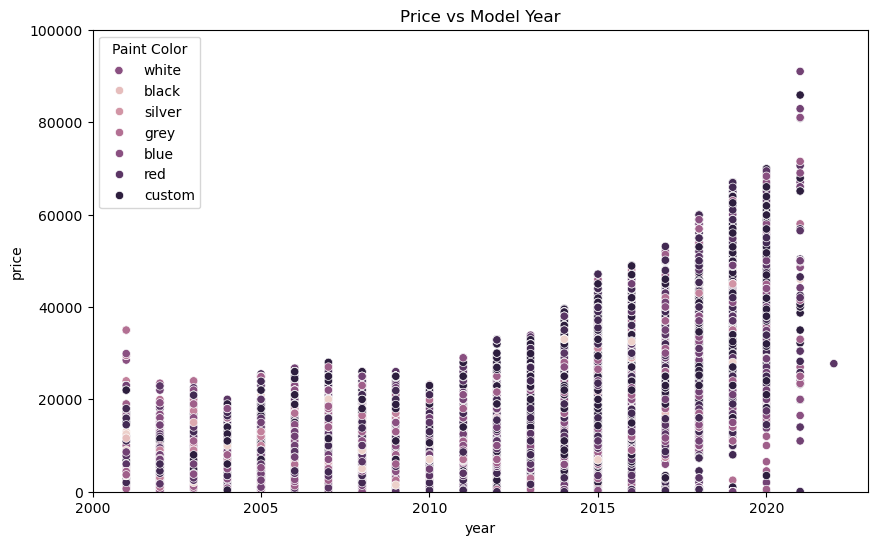

In [1650]:
plt.subplots(figsize=(10, 6))
sns.scatterplot(data=df_filt_sigma, x="year", y="price", hue="paint_code")
plt.title("Price vs Model Year")
plt.legend(title='Paint Color', labels=['white','black','silver','grey','blue','red','custom','green','brown','yellow','orange','purple'])
plt.ylim(0, 100000)
plt.xlim(2000, 2023)

(2000.0, 2023.0)

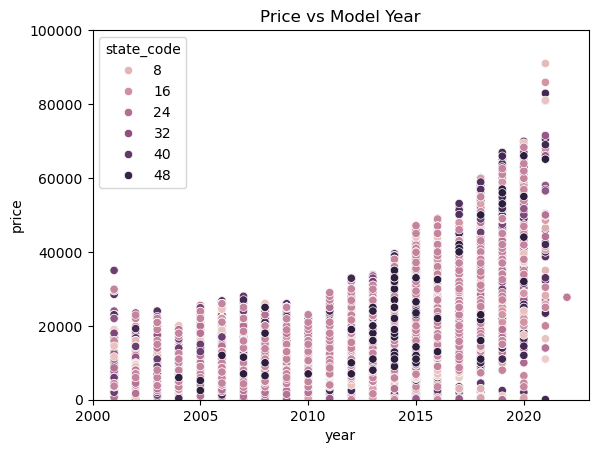

In [1652]:
sns.scatterplot(data=df_filt_sigma, x="year", y="price", hue="state_code")
plt.title("Price vs Model Year")
plt.ylim(0, 100000)
plt.xlim(2000, 2023)

(2000.0, 2023.0)

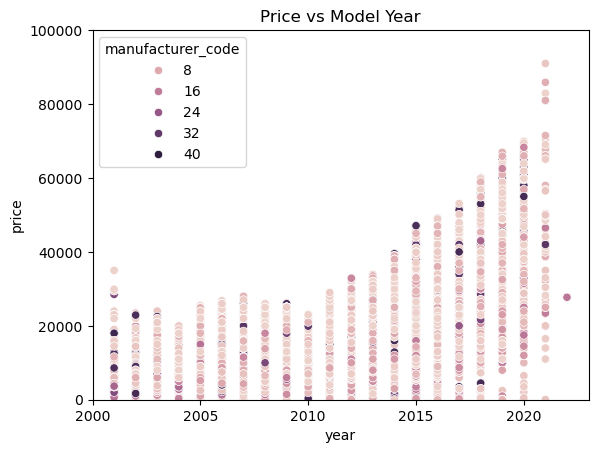

In [1654]:
sns.scatterplot(data=df_filt_sigma, x="year", y="price", hue="manufacturer_code")
plt.title("Price vs Model Year")
plt.ylim(0, 100000)
plt.xlim(2000, 2023)

In [1657]:
df_filt_sigma.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,...,state,type_code,size_code,condition_code,fuel_code,cylinder_code,title_code,paint_code,state_code,manufacturer_code
215,7.316482e+09,birmingham,4000.0,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,...,al,1.0,2,4,1.0,2.0,6,8,27,3.0
268,7.315946e+09,birmingham,9000.0,2008.0,mazda,miata mx-5,excellent,4 cylinders,gas,56700.0,...,al,4.0,2,4,1.0,2.0,6,12,27,15.0
337,7.315354e+09,birmingham,8950.0,2011.0,ford,f-150,excellent,6 cylinders,gas,164000.0,...,al,5.0,4,4,1.0,4.0,6,12,27,1.0
355,7.315111e+09,birmingham,9400.0,2008.0,mercedes-benz,benz c350,good,6 cylinders,gas,129473.0,...,al,1.0,4,3,1.0,4.0,6,10,27,36.0
364,7.314968e+09,birmingham,7300.0,2007.0,lexus,rx350,good,6 cylinders,gas,181000.0,...,al,8.0,3,3,1.0,4.0,6,12,27,33.0


In [1661]:
df_filt_sigma.tail()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,...,state,type_code,size_code,condition_code,fuel_code,cylinder_code,title_code,paint_code,state_code,manufacturer_code
426784,7.303329e+09,wyoming,24995.0,2014.0,gmc,sierra,good,8 cylinders,gas,128722.0,...,wy,5.0,4,3,1.0,5.0,6,12,50,7.0
426785,7.303315e+09,wyoming,23495.0,2015.0,ford,f150 xlt 4x4,like new,8 cylinders,gas,146795.0,...,wy,5.0,4,5,1.0,5.0,6,11,50,1.0
426788,7.303228e+09,wyoming,12995.0,2016.0,chevrolet,cruze lt,like new,4 cylinders,gas,61127.0,...,wy,1.0,2,5,1.0,2.0,6,10,50,2.0
426792,7.303115e+09,wyoming,32999.0,2014.0,ford,"f350, xlt",excellent,8 cylinders,diesel,154642.0,...,wy,6.0,4,4,2.0,5.0,6,1,50,1.0
426793,7.303112e+09,wyoming,15999.0,2018.0,chevrolet,"cruze, lt",excellent,4 cylinders,gas,36465.0,...,wy,1.0,3,4,1.0,2.0,6,11,50,2.0


In [1665]:
# take only the numerical fields of interest

#df_filt_sigma[['price','year','odometer','type_code','size_code','condition_code','fuel_code','cylinder_code','title_code','paint_code','state_code','manufacturer_code']]
#

clean_df = df_filt_sigma[['price','year','odometer','type_code','size_code','condition_code','fuel_code','cylinder_code','title_code','paint_code','state_code','manufacturer_code']]
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28419 entries, 215 to 426793
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              28419 non-null  float64
 1   year               28419 non-null  float64
 2   odometer           28419 non-null  float64
 3   type_code          28419 non-null  float64
 4   size_code          28419 non-null  int64  
 5   condition_code     28419 non-null  int64  
 6   fuel_code          28419 non-null  float64
 7   cylinder_code      28419 non-null  float64
 8   title_code         28419 non-null  int64  
 9   paint_code         28419 non-null  int64  
 10  state_code         28419 non-null  int64  
 11  manufacturer_code  28419 non-null  float64
dtypes: float64(7), int64(5)
memory usage: 2.8 MB


In [1675]:
# scale my values fot between 0 and 1 
# to remove terms like odometer from dominating
# the model

ss = MinMaxScaler()
rescaled_df = pd.DataFrame(ss.fit_transform(clean_df), columns = ss.get_feature_names_out())
rescaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28419 entries, 0 to 28418
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              28419 non-null  float64
 1   year               28419 non-null  float64
 2   odometer           28419 non-null  float64
 3   type_code          28419 non-null  float64
 4   size_code          28419 non-null  float64
 5   condition_code     28419 non-null  float64
 6   fuel_code          28419 non-null  float64
 7   cylinder_code      28419 non-null  float64
 8   title_code         28419 non-null  float64
 9   paint_code         28419 non-null  float64
 10  state_code         28419 non-null  float64
 11  manufacturer_code  28419 non-null  float64
dtypes: float64(12)
memory usage: 2.6 MB


In [1677]:
# create the training and test data set

X_train, X_test, y_train, y_test = train_test_split(rescaled_df.drop('price', axis=1), rescaled_df['price'], test_size = 0.3, random_state = 42)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [1703]:
# Linear Model
linear_model = LinearRegression()
linear_model.fit(X_train,y_train)

linear_train_preds = linear_model.predict(X_train)
linear_test_preds = linear_model.predict(X_test)
linear_train_mse = mean_squared_error(y_train, linear_train_preds)
linear_test_mse = mean_squared_error(y_test, linear_test_preds)
linear_coefficients = linear_model.coef_

In [1960]:
# create pipeline

poly_train_mse_array = []
poly_test_mse_array = []
poly_coefficients_array = []

for i in range (1, 10, 2):
    scaled_ridge_model = Pipeline([('sales_transform', PolynomialFeatures(degree = i, include_bias = False)),
                               ('sales_regression', Ridge(alpha = 1))])
    # fit the model
    scaled_ridge_model.fit(X_train,y_train)
    
    # create the prediction on the training and test set
    # running the analysis, the test mse is similar to the 
    # training mse indicating a pretty good model

    poly_train_preds = scaled_ridge_model.predict(X_train)
    poly_test_preds = scaled_ridge_model.predict(X_test)
    poly_train_mse = mean_squared_error(y_train, poly_train_preds)
    poly_test_mse = mean_squared_error(y_test, poly_test_preds)
    poly_coefficients = scaled_ridge_model.named_steps['sales_regression'].coef_

    poly_train_mse_array.append(poly_train_mse)
    poly_test_mse_array.append(poly_test_mse)
    poly_coefficients_array.append(poly_coefficients)

In [1962]:
# Run a grid search to find optimal alpha
# some trial and error before settling on in the 41 
# range

pipe = Pipeline([('ridge', Ridge())])
param_dict = {'ridge__alpha': [41, 41.1, 41.2, 41.3]}

grid_2 = GridSearchCV(pipe, param_grid=param_dict)
grid_2.fit(rescaled_df.drop('price', axis=1), rescaled_df['price'])
model_best_params = grid_2.cv_results_ 

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [1965]:
# show me the data from the
# linear model

print("training mse is ", linear_train_mse)
print("test mse is ", linear_test_mse)

training mse is  0.006532390659139967
test mse is  0.006707181010956457


In [1967]:
# show me the coefficients based off the linear model

linear_coefficients

array([ 0.24456268, -0.19777919,  0.03013937,  0.06857151,  0.03060718,
        0.20233338,  0.1862812 ,  0.05047318,  0.00257662, -0.00423193,
       -0.03038642])

In [1969]:
# show me the data from the
# polynomial model
# this model has the best error
# but is impossible to interpret/analyze
# and it improves the higher the order
# of the analysis so it was inconclusive

print("training mse is ", poly_train_mse_array)
print("test mse is ", poly_test_mse_array)

training mse is  [0.006532409452755361, 0.0037617290035583087, 0.0032764962672685374, 0.002910872309874212, 0.0026088447043674046]
test mse is  [0.006707586737730332, 0.003919616658322686, 0.00354342786587832, 0.003316024046471655, 0.0031673219645035173]


In [1958]:
poly_coefficients_array

[array([ 0.24439756, -0.19737623,  0.03013865,  0.06861706,  0.03070676,
         0.20142218,  0.18599443,  0.0499968 ,  0.0026757 , -0.00421047,
        -0.03039898]),
 array([-0.20149093, -0.00809559,  0.14753476, -0.14377731,  0.0163516 ,
         0.08281231,  0.10217948,  0.0915445 , -0.023199  , -0.02388686,
        -0.07005299,  0.26690385, -0.13471161,  0.07876703,  0.20944881,
         0.04321476,  0.36018442,  0.09125239,  0.01447747, -0.04834567,
        -0.01557466,  0.01551527,  0.07877712, -0.0288587 , -0.07294423,
         0.08002538, -0.03230388, -0.11869301, -0.12830381, -0.00375056,
         0.09397571,  0.02985206, -0.34641911,  0.00740343,  0.01984817,
         0.08687435,  0.06747724,  0.05259233,  0.01234728,  0.00904543,
        -0.04755431, -0.02163828, -0.04749329,  0.11447433,  0.2459147 ,
         0.02921427,  0.01383972,  0.05378713,  0.04111053, -0.01089197,
        -0.06637386,  0.03684837, -0.02189116, -0.01864907,  0.05360802,
         0.01602554, -0.4228

In [1930]:
# show me the grid score data

model_best_params

{'mean_fit_time': array([0.00269685, 0.00345769, 0.00275702, 0.00177541]),
 'std_fit_time': array([0.00132194, 0.00031195, 0.00114557, 0.00104579]),
 'mean_score_time': array([0.00294666, 0.00130463, 0.00078931, 0.00046721]),
 'std_score_time': array([0.00206168, 0.00030694, 0.00048135, 0.00024648]),
 'param_ridge__alpha': masked_array(data=[41, 41.1, 41.2, 41.3],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'ridge__alpha': 41},
  {'ridge__alpha': 41.1},
  {'ridge__alpha': 41.2},
  {'ridge__alpha': 41.3}],
 'split0_test_score': array([0.48646894, 0.48648967, 0.48651037, 0.48653104]),
 'split1_test_score': array([0.25668599, 0.2567279 , 0.25676978, 0.25681162]),
 'split2_test_score': array([0.641858  , 0.64183071, 0.64180342, 0.64177613]),
 'split3_test_score': array([0.61275692, 0.61274613, 0.61273533, 0.61272452]),
 'split4_test_score': array([0.65895115, 0.65892662, 0.65890209, 0.65887756]),
 'mean_test_score': arra

In [1913]:
# show me the coefficients based off ultimate alpha

model_best_coef

array([ 0.04851393, -0.02996651,  0.00871095,  0.0178517 ,  0.0047989 ,
        0.02019778,  0.03561126,  0.0036288 ,  0.00167241, -0.00098332,
       -0.00813068])

In [1950]:
print("mean of Grid is", statistics.mean(model_best_params['mean_test_score']))

mean of Grid is 0.5313441941879545


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

In [ ]:
## See "What drives the price of a car?" document for summary of my report to the client